# Submission Sistem Rekomendasi Anime

Nama: Anthony Kevin Oktavius


Library Imports

In [1]:
import numpy as np
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from google.colab import files
from scipy.stats.stats import kendalltau
from pylab import rcParams
%matplotlib inline

Kaggle Upload

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Kaggle.json has been uploaded!')

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Kaggle.json has been uploaded!


Dataset Download

In [3]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip -o anime-recommendations-database.zip

 64% 16.0M/25.0M [00:00<00:00, 54.8MB/s]
100% 25.0M/25.0M [00:00<00:00, 66.9MB/s]
Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


Anime Dataset Preview

In [4]:
anime_dataset_name = "anime.csv"
anime_df = pd.read_csv(anime_dataset_name)
anime_df 

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


Rating Dataset Preview

In [5]:
anime_rating_name = "rating.csv"
anime_rating_df = pd.read_csv(anime_rating_name)
anime_rating_df 

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Inisialisasi field pada masing-masing data, agar field-field tersebut lebih mudah dikelola.

In [6]:
# Field yang ada pada kedua dataset
anime_id_field = "anime_id"
rating_field = "rating"


# Field-field pada rating
name_field = "name"
genre_field = "genre"
type_field = "type"
episodes_field = "episodes"
rating_field = "rating"
members_field = "members"

# Field-field pada rating dataset
user_id_field = "user_id"
user_rating_field = "user_rating"

## Exploratory Data Analysis

Definisi fungsi untuk kebutuhan eksplorasi data

In [7]:
def plot_continous_data(plot_title, x_title, y_title, data):
  plt.plot(data)
  plt.title(plot_title)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.show()

def dynamically_increment_update(dictionary, key, increment_value):
   try:
      dictionary[key] = dictionary[key] + increment_value
   except KeyError:
      dictionary[key] = increment_value
  
   return dictionary

### Exploratory Data Analysis Anime

#### Variable Analysis

Melihat deskripsi data dengan numpy dengan info() dan describe(). 

* **info()**: menjelaskan jumlah kolom yang non-null dan data type.
    
* **describe()**: menjelaskan beberapa informasi mengenai statistika suatu data.

In [8]:
anime_df_analysis = anime_df

Melihat jumlah kolom yang non-null dan data type 

In [9]:
anime_df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [10]:
anime_df_analysis.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


#### Missing Value

Menghapus data yang null, karena kita masih punya 12017 data.

In [11]:
anime_df_analysis.dropna(inplace=True)
anime_df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


Melihat jumlah episode yang "unknown"

In [12]:
anime_df_analysis[anime_df_analysis[episodes_field].str.contains("Unknown")].sum()

anime_id                                              5316763
name        One PieceDetective ConanNaruto: ShippuudenCray...
genre       Action, Adventure, Comedy, Drama, Fantasy, Sho...
type        TVTVTVTVSpecialTVTVSpecialTVTVTVTVONATVTVTVTVT...
episodes    UnknownUnknownUnknownUnknownUnknownUnknownUnkn...
rating                                                1136.38
members                                               1513316
dtype: object

Hapus field-field episodes yang memiliki data "Unknown"

In [13]:
anime_df_analysis = anime_df_analysis.drop(anime_df_analysis[anime_df_analysis[episodes_field].str.contains("Unknown")].index)

Ubah field episodes menjadi tipe float64

In [14]:
anime_df_analysis[episodes_field] = anime_df_analysis[episodes_field].astype(
    'float64'
)

Menjelaskan kembali beberapa informasi mengenai statistika pada data anime.

In [15]:
anime_df_analysis.describe()

,anime_id,episodes,rating,members
count,11830.000000,11830.000000,11830.000000,1.183000e+04
mean,13404.150211,12.486729,6.484609,1.851100e+04
std,11110.087616,47.097131,1.019147,5.537144e+04
min,1.000000,1.000000,1.670000,1.200000e+01
25%,3326.250000,1.000000,5.892500,2.322500e+02
50%,9820.500000,2.000000,6.570000,1.589500e+03
75%,23302.500000,12.000000,7.190000,9.832000e+03
max,34519.000000,1818.000000,10.000000,1.013917e+06


#### Eskplorasi Data Genre

In [16]:
genres_anime_data = anime_df_analysis[genre_field]
genres_anime_data

0                     Drama, Romance, School, Supernatural
1        Action, Adventure, Drama, Fantasy, Magic, Mili...
2        Action, Comedy, Historical, Parody, Samurai, S...
3                                         Sci-Fi, Thriller
4        Action, Comedy, Historical, Parody, Samurai, S...
                               ...                        
12289                                               Hentai
12290                                               Hentai
12291                                               Hentai
12292                                               Hentai
12293                                               Hentai
Name: genre, Length: 11830, dtype: object

In [17]:
number_per_genre = dict()

for i in range(len(genres_anime_data)):
  genre_anime_data = genres_anime_data.iloc[[i][0]]
  splitted_text = genre_anime_data.split(', ')

  # Mendapatkan masing-masing genre
  for i in range(len(splitted_text)):
    number_per_genre = dynamically_increment_update(number_per_genre, 
                                                    splitted_text[i], 
                                                    1)

key_genre_dictionary = list(number_per_genre.keys())
value_genre_dictionary = list(number_per_genre.values())

**Visualisasi Data Genre yang ada dengan menggunakan tabel**

Melihat jumlah data pada genre individual.

In [18]:
count_field = "Count"

anime_genre_dataframe = pd.DataFrame(
    data = value_genre_dictionary,
    index = key_genre_dictionary,
    columns = [count_field]
)

print(f"Total anime genres: {anime_genre_dataframe.shape[0]}")
anime_genre_dataframe.sort_values(by=count_field, ascending=False)

Total anime genres: 43


,Count
Comedy,4483
Action,2748
Adventure,2293
Fantasy,2219
Sci-Fi,2028
Drama,1972
Shounen,1669
Kids,1550
Romance,1436
Slice of Life,1180


#### Explorasi Data Type

Melakukan persebaran data type dengan menggunakan value_counts. Lalu, saya menggunakan plot bar untuk melihat persebaran tipe anime.

In [19]:
anime_types_data = anime_df_analysis[type_field]
anime_types_data

0        Movie
1           TV
2           TV
3           TV
4           TV
         ...  
12289      OVA
12290      OVA
12291      OVA
12292      OVA
12293    Movie
Name: type, Length: 11830, dtype: object

In [20]:
count_anime_types = anime_types_data.value_counts()

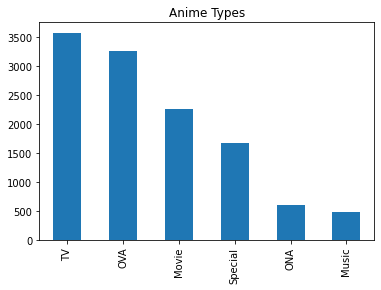

In [21]:
count_anime_types.plot(kind='bar', title = "Anime Types")

#### Ekplorasi Data Episodes

Melihat persebaran data episode dengan menggunakan plot histogram.

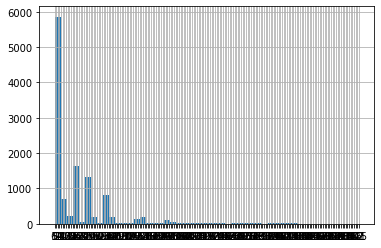

In [22]:
anime_df[episodes_field].hist(bins=50)

#### Eksplorasi Data Rating

Visualisasi Data Rating

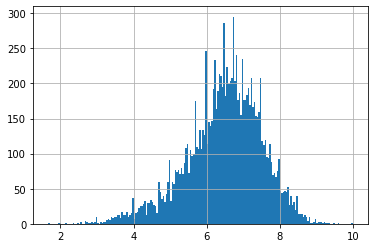

In [23]:
anime_df[rating_field].hist(bins=200)

### Exploratory Data Analysis Rating

#### Variable Analysis

Melihat jumlah kolom yang non-null dan data type 

In [24]:
anime_rating_analysis_df = anime_rating_df
anime_rating_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Menjelaskan beberapa informasi mengenai statistika pada data rating.

In [25]:
anime_rating_analysis_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


##### Eksplorasi Data Rating

Melihat persebaran data anime rating dengan menggunakan plot histogram.



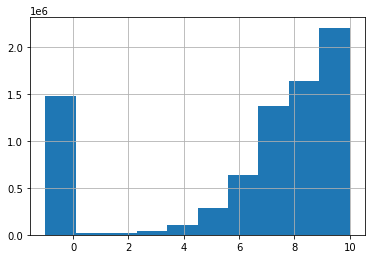

In [26]:
anime_rating_analysis_df[rating_field].hist()

Menghapus rating yang memiliki rating -1. -1 artinya adalah user belum melakukan rating sama sekali.

In [27]:
anomaly_ratings_df = anime_rating_analysis_df[anime_rating_analysis_df[rating_field] == -1]

print(f"Total number of -1: {len(anomaly_ratings_df)}")

anime_rating_analysis_df.drop(
    anomaly_ratings_df.index, 
    inplace=True)

print(len(anime_rating_analysis_df))

Total number of -1: 1476496
6337241


### Melihat jumlah user, place, dan rating yang tidak duplikat pada dataset rating

In [28]:
print("Unique Data:")

print(f"Total user_id: {len(anime_rating_analysis_df[user_id_field].unique())}")
print(f"Total anime_id: {len(anime_rating_analysis_df[anime_id_field].unique())}")
print(f"Total rating: {len(anime_rating_analysis_df[rating_field].unique())}")

Unique Data:
Total user_id: 69600
Total anime_id: 9927
Total rating: 10


## Data Preparation dan Modelling

In [45]:
anime_rating_cbf_df = anime_rating_analysis_df
anime_cbf_df = anime_df_analysis

### Content based filtering Cosine Similarity dan TF IDF Vectorizer

* **TF IDF Vectorizer:**

  TD-IDF (Term Frequency - Inverse Document Frequency) mengukur seberapa pentingnya suatu kata terhadap kata-kata lain dalam dokumen. Ia dibagi menjadi 2 komponen, yaitu TF dan IDF.

  * TF mengukur seberapa sering kata muncul dalam teks tertentu. Teks yang berbeda dalam dokumen mungkin panjangnya berbeda, karena ada faktor dari panjang dokumen. Teks yang berbeda memiliki panjang yang berbeda. Maka dari itu, harus dinormalisasi dengan membagi jumlah kemunculan terhadap panjang dokumen.

  * IDF mengukur pentingnya suatu istilah di dalam korpus. Ia memastikan agar kepentingan suatu kata di dalam kalimat itu sama. Misalkan stop words seperti is, am, are, dsb sering muncul di suatu kalimat, namun mereka tidak penting kehadirannya. Maka dari itu, semua kata dinormalisasikan agar setiap kata bisa mendapatkan nilai kepentingan yang fair.

  Dari kesimpulan di atas, kita bisa mendapatkan rumus sebagai berikut.

  ![Rumus TF-IDF](https://cdn-media-1.freecodecamp.org/images/1*nSqHXwOIJ2fa_EFLTh5KYw.png)

  Dalam fungsi ini, kita bisa menggunakan TfIdfVectorizer. TFIdfVectorizer adalah salah satu fungsi yang disediakan dari sklearn.

* **Cosine Similarity:**

  Cosine similarity adalah salah satu metrik untuk mengukur kesamaan. Cosine similarity mengukur kesamaan dua vektor dengan menentukan apakah kedua vektornya sudah mengarah kepada arah yang sama. Semakin kecil sudut cosinus, semakin besar nilai cosine similarity.

  Metrik ini sering digunakan untuk analisis teks. Dalam hal ini, dari hasil TF IDF, kita akan mengukur kesamaan antar satu item dengan fitur yang ada pada item tersebut, sehingga kita bisa merekomendasikan anime yang cocok dengan genre yang diberikan.

  Rumusnya adalah sebagai berikut.

    ![Rumus Cosine Similarity](https://neo4j.com/docs/graph-data-science/current/_images/cosine-similarity.png)


In [46]:
anime_genre_cbf_df = anime_cbf_df[genre_field].to_list()
anime_genre_cbf_df[:5]

['Drama, Romance, School, Supernatural',
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
 'Sci-Fi, Thriller',
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen']

#### Data Preparation dan Training Model

**Data Preparation:**

Melakukan splitting value ketika ada tanda koma (,), agar kita bisa merekomendasikan anime yang memiliki genre tambahan selain genre yang ditentukan.



In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

def split_token(value):
  return value.split(', ')

tf_idf_vectorizer = TfidfVectorizer(tokenizer = split_token)

tf_idf_vectorizer.fit(anime_genre_cbf_df)

tf_idf_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'magic',
 'martial arts',
 'mecha',
 'military',
 'music',
 'mystery',
 'parody',
 'police',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci-fi',
 'seinen',
 'shoujo',
 'shoujo ai',
 'shounen',
 'shounen ai',
 'slice of life',
 'space',
 'sports',
 'super power',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri']

Mengecek ukuran bentuk matriks pada data anime_id dan genre.

In [48]:
tf_idf_matrix = tf_idf_vectorizer.fit_transform(anime_genre_cbf_df)

tf_idf_matrix.shape

(11830, 43)

Melakukan testing dengan data pada indeks pertama

In [49]:
tf_idf_matrix.todense()[0]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.43832909, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.48811086, 0.        , 0.52106389, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.54599252, 0.        ,
         0.        , 0.        , 0.        ]])

Mengukur kesamaan antar elemen yang satu dengan elemen yang lain, dengan menggunakan cosine similarity

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_value = cosine_similarity(tf_idf_matrix)
cosine_similarity_value

array([[1.        , 0.1464293 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1464293 , 1.        , 0.18834688, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18834688, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [51]:
cosine_similarity_df = pd.DataFrame(
    cosine_similarity_value,
    index = anime_cbf_df[name_field],
    columns = anime_cbf_df[name_field]
)

cosine_similarity_df

name,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood,Gintama°,Steins;Gate,Gintama&#039;,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,Gintama&#039;: Enchousen,...,Silent Chaser Kagami,Super Erotic Anime,Teleclub no Himitsu,Tenshi no Habataki Jun,The Satisfaction,Toushindai My Lover: Minami tai Mecha-Minami,Under World,Violence Gekiga David no Hoshi,Violence Gekiga Shin David no Hoshi: Inma Densetsu,Yasuji no Pornorama: Yacchimae!!
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,1.000000,0.146429,0.000000,0.000000,0.000000,0.424715,0.000000,0.166339,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fullmetal Alchemist: Brotherhood,0.146429,1.000000,0.188347,0.000000,0.188347,0.284837,0.411651,0.434373,0.188347,0.188347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama°,0.000000,0.188347,1.000000,0.124379,1.000000,0.193237,0.248584,0.110365,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steins;Gate,0.000000,0.000000,0.124379,1.000000,0.124379,0.000000,0.000000,0.159058,0.124379,0.124379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama&#039;,0.000000,0.188347,1.000000,0.124379,1.000000,0.193237,0.248584,0.110365,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Under World,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Violence Gekiga David no Hoshi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Melakukan Top N Recommendation

Mulai melakukan rekomendasi pada data anime

In [53]:
def get_anime_recommendations(anime_name,
                              similarity_data = cosine_similarity_df,
                              items = anime_cbf_df[[name_field, genre_field]],
                              k = 4):
  
  print(range(-1, -k, -1))

  index = similarity_data.loc[:, anime_name].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  return pd.DataFrame(closest).merge(items).head(k)

Melihat contoh data yang memiliki genre Drama

In [58]:
anime_cbf_df[anime_cbf_df[genre_field].str.contains('Drama')]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.0,9.15,93351
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110.0,9.11,80679
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24.0,9.06,456749
...,...,...,...,...,...,...,...
12005,3976,Mamahaha,"Drama, Hentai, Romance",OVA,2.0,5.74,1546
12017,2218,Fujimi 2-choume Koukyougakudan,"Drama, Music, Psychological, Romance, Slice of...",OVA,1.0,5.72,4981
12071,3396,Gloria: Kindan no Ketsuzoku,"Drama, Hentai, Mystery, Romance",OVA,3.0,5.61,654
12143,4697,Chimera: Target I Datenshi Kourin,"Drama, Hentai",OVA,1.0,5.46,841


Mendapatkan top N rekomendasi

In [59]:
anime_recommendations = get_anime_recommendations('Kimi no Na wa.')
anime_recommendations

range(-1, -4, -1)


,name,genre
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,Wind: A Breath of Heart OVA,"Drama, Romance, School, Supernatural"
2,Wind: A Breath of Heart (TV),"Drama, Romance, School, Supernatural"
3,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural"


#### Melakukan evaluasi dengan metrik akurasi.

In [60]:
def get_accuracy_content_based_filtering_metrics(df, 
                                                 comparation_index, 
                                                 field_to_be_compared,
                                                 expected_name):

  number_of_rows = df.shape[0]
  one_correct_value = 100.0 / len(df)
  total_accuracy_score = 0

  for index in range(number_of_rows):
    if index == comparation_index:
      continue

    if expected_name in df[field_to_be_compared][index]:
      total_accuracy_score += one_correct_value

  return total_accuracy_score

In [61]:
genre_accuracy_score = get_accuracy_content_based_filtering_metrics(anime_recommendations,
                                                                    -1,
                                                                    genre_field,
                                                                    "Drama")

print(f"Accuracy Score: {genre_accuracy_score}%")

Accuracy Score: 100.0%


### Collaborative Filtering dengan SVD (Matrix Factorization)


SVD adalah salah satu teknik yang digunakan untuk dimensionality reduction. Teknik ini bekerja dengan mengurangi jumlah fitur yang ada pada dataset (mirip dengan PCA) dengan jumlah fitur yang ditentukan oleh user.

Namun, jika kita berbicara konteks sistem rekomendasi, SVD menggunakan sturktur matriks. Berikut adalah bagian-bagian dari SVD, jika menggunakan struktur matriks. 

  * Bagian row menunjukkan user
  * Bagian column menunjukkan item
  * Elemen-elemen pada matriks menunjukkan rating

Dari matriks di atas, SVD mengurangi dimensi matriks terebut dengan faktor-faktor laten. Ia melakukan mapping setiap fitur dan item menjadi matriks yang lebih kecil. Matriks inilah yang memiliki informasi mengenai relasi user dan item.

Rumus untuk SVD adalah sebagai berikut.

![Rumus SVD](https://miro.medium.com/max/894/1*XNWUlrQJXGeoCDqUMd0iUA.png)

Untuk melakukan training pada SVD, ia menggunakan teknik SGD (Schocastic Gradient Descent). SGD bekerja dengan meminimalkan nilai awal dan melakukan iterasi untuk mengurangi kesalahan antara nilai yang diprediksi dan nilai aktual. Mirip seperti SGD pada klasifikasi, ia akan mengoptimalkan cost function agar bisa konvergensi ke titik global optima.


Impor Library yang akan digunakan untuk collaborative filtering

In [62]:
!pip install surprise
import surprise
from surprise import SVD
from surprise import accuracy
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate
from collections import defaultdict

     |████████████████████████████████| 11.8 MB 5.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630174 sha256=23bae0201b8daa8aa64f87cc870ad8600cf5d1b21808155b08378aa9e7e33411
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


#### Data Preparation

In [63]:
anime_rating_cbf_df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


**Standardisasi Nilai Rating**

Melakukan standardisasi pada nilai rating, agar machine learning bisa lebih cepat mempelajari data (terutama jika berbicara mengenai jarak dan gradient descent), dengan skala antara 0 - 1.

In [65]:
anime_rating_cbf_df[rating_field] = anime_rating_cbf_df[rating_field].apply(
    lambda x: (x - 1) / (10 - 1)
).values
anime_rating_cbf_df.describe()

,user_id,anime_id,rating
count,6.337241e+06,6.337241e+06,6.337241e+06
mean,3.674791e+04,8.902866e+03,7.564997e-01
std,2.101340e+04,8.882000e+03,1.747218e-01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.898400e+04,1.239000e+03,6.666667e-01
50%,3.681500e+04,6.213000e+03,7.777778e-01
75%,5.487300e+04,1.407500e+04,8.888889e-01
max,7.351600e+04,3.447500e+04,1.000000e+00


**Train Tets Split**

Melakukan train test split, dengan proporsi sebagai berikut:

* **Train:** 80%
* **Test:** 20%

Tujuan dari pembagian data ini adalah agar kita bisa mengukur kemampuan machine learning dengan data yang belum pernah dipelajari. 



In [66]:
anime_rating_train_data, anime_rating_test_data = train_test_split(
    anime_rating_cbf_df,
    test_size = 0.2,
    random_state = 30
)

#### Training Model

Melakukan konversi dataframe menjadi data yang bisa dibaca dengan library surprise.

In [67]:
data_reader = surprise.Reader(rating_scale=(0,1))

train_surprise_data = surprise.Dataset.load_from_df(
    anime_rating_train_data, 
    data_reader
)

test_surprise_data = surprise.Dataset.load_from_df(
    anime_rating_test_data, 
    data_reader
)

anime_trainset_surprise = train_surprise_data.build_full_trainset()

Collaborative Filtering menggunakan SVD (Matrix Facrorization Technique). Di sini, saya akan menggunakan attribut pada genre

In [68]:
svd_classifier = SVD(n_epochs = 3, verbose=True)
anime_predictor_surprise = svd_classifier.fit(anime_trainset_surprise)

Processing epoch 0
Processing epoch 1
Processing epoch 2


#### Evaluasi Model

Dalam collaborative filtering, terdapat dua metrik yang saya gunakan, yaitu MAE dan RMSE. 

* **MAE**: rata-rata kesalahan absolut antara data sebenarnya dengan data yang diprediksikan. Rumusnya adalah sebagai berikut:

  ![Rumus MAE](https://www.statisticshowto.com/wp-content/uploads/2016/10/MAE.png)

* **RMSE**: akar kuadrat dari MSE. MSE sendiri adalah kuadrat dari rata-rata kesalahan. Rumusnya adalah sebagai berikut.

  ![Rumus RMSE](https://1.bp.blogspot.com/-AodtifmdR1U/X-NOXo0avGI/AAAAAAAACmI/_jvy7eLB72UB00dW_buPYZCa9ST2yx8XACNcBGAsYHQ/s453/rumus%2Brmse.jpg)

Mendapatkan nilai MAE dan RMSE

In [69]:
cross_validate(svd_classifier, 
               train_surprise_data, 
               measures = ['RMSE', 'MSE'], 
               cv = 3,
               verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 0
Processing epoch 1
Processing epoch 2
Evaluating RMSE, MSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1478  0.1476  0.1478  0.1478  0.0001  
MSE (testset)     0.0218  0.0218  0.0219  0.0218  0.0000  
Fit time          36.71   38.20   39.11   38.01   0.99    
Test time         36.84   38.53   37.52   37.63   0.69    


{'fit_time': (36.71338868141174, 38.1976101398468, 39.10872268676758),
 'test_mse': array([0.02184725, 0.02179346, 0.02185931]),
 'test_rmse': array([0.14780814, 0.14762607, 0.14784894]),
 'test_time': (36.84397292137146, 38.52534222602844, 37.51636838912964)}

Melakukan prediksi dengan data testing

In [70]:
anime_trainset_test_surprise = test_surprise_data.build_full_trainset()
anime_surprise_testset = anime_trainset_test_surprise.build_testset()

predictions = anime_predictor_surprise.test(anime_surprise_testset)

#### Melihat top n rekomendasi dengan sampel user id 23435

In [71]:
predict_user_id = 23435

Melihat hasil prediksi rating dari user-user pada data testing

In [72]:
for index, prediction in enumerate(predictions):
  if prediction[0] == predict_user_id:
    print(prediction)

user: 23435      item: 24415      r_ui = 1.00   est = 1.00   {'was_impossible': False}
user: 23435      item: 551        r_ui = 0.78   est = 0.83   {'was_impossible': False}
user: 23435      item: 22789      r_ui = 1.00   est = 0.95   {'was_impossible': False}
user: 23435      item: 6974       r_ui = 0.78   est = 0.86   {'was_impossible': False}
user: 23435      item: 4224       r_ui = 1.00   est = 0.95   {'was_impossible': False}
user: 23435      item: 5040       r_ui = 1.00   est = 0.93   {'was_impossible': False}
user: 23435      item: 5681       r_ui = 1.00   est = 0.91   {'was_impossible': False}
user: 23435      item: 6213       r_ui = 0.89   est = 0.90   {'was_impossible': False}
user: 23435      item: 431        r_ui = 0.67   est = 0.98   {'was_impossible': False}
user: 23435      item: 11577      r_ui = 1.00   est = 0.94   {'was_impossible': False}
user: 23435      item: 237        r_ui = 0.89   est = 0.92   {'was_impossible': False}
user: 23435      item: 10408      r_ui = 0.

Melakukan rekomendasi anime

In [73]:
def get_top_n_from_specific_user_id(predictions, 
                                    number_of_items,
                                    user_id,
                                    except_array=[]):
  top_n = defaultdict(list)

  # Membuat pemetaan user terlebih dahulu, dengan melihat terlebih dahulu
  # apakah user tersebut sudah pernah menonton movie tersebut
  for uid, iid, true_r, est, _ in predictions:
    if user_id == uid and iid not in except_array:
      top_n[uid].append((iid, est))

  # Melakukan pengurutan ranking pada user yang diberikan pada argument
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:number_of_items]

  return top_n

watched_animes = anime_rating_cbf_df[anime_rating_cbf_df[user_id_field] == predict_user_id]
top_n_animes = get_top_n_from_specific_user_id(predictions,
                                               number_of_items = 5,
                                               user_id = predict_user_id,
                                               except_array = watched_animes)

top_n_animes = top_n_animes[predict_user_id]

In [77]:
print(f"Recommendation for user id: {predict_user_id}")

recommended_animes = []

for i, recommended_anime_id in enumerate(top_n_animes):
  recommended_animes.append(recommended_anime_id[0])

recommended_anime_names = anime_cbf_df[anime_cbf_df[anime_id_field].isin(recommended_animes)]
recommended_anime_names

Recommendation for user id: 23435


,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
32,5258,Hajime no Ippo: New Challenger,"Comedy, Drama, Shounen, Sports",TV,26.0,8.75,88995
43,20583,Haikyuu!!,"Comedy, Drama, School, Shounen, Sports",TV,25.0,8.68,284498
58,24415,Kuroko no Basket 3rd Season,"Comedy, School, Shounen, Sports",TV,25.0,8.62,184525
814,27991,K: Return of Kings,"Action, Super Power, Supernatural",TV,13.0,7.82,114904
